# COVID-19 Prediction Analysis on Locations with 

In [1]:
# Suppress warning messages
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Import general dependencies
import os 
import pandas as pd
from pprint import pprint
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import datetime

In [3]:
# Import machine learning dependencies 
import sklearn as skl
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
# from imblearn.metrics import classificationn_report_imbalanced 
from sklearn import metrics 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
import seaborn as sns
# import keras_tuner as kt

## Data Source

In [4]:
# Load the cases prediction cleaned data file.
cases_700_file_path = Path('./Resources/cases_1mill_700_df.csv')
df = pd.read_csv(cases_700_file_path)
print(df.shape)
df.head()

(84848, 26)


,id_row,location,covid_days,total_cases,new_cases,reproduction_rate,total_vaccinations,people_fully_vaccinated,stringency_index,population,...,life_expectancy,human_development_index,daily_vaccinations,daily_people_fully_vaccinated,total_cases_per_100K,new_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K
0,34,Afghanistan,88,114.0,8.0,1.52,0.0,0.0,67.59,39835428.0,...,64.83,0.511,0.0,0.0,0.2862,0.0201,0.0,0.0,0.0,0.0
1,35,Afghanistan,89,114.0,0.0,1.52,0.0,0.0,67.59,39835428.0,...,64.83,0.511,0.0,0.0,0.2862,0.0000,0.0,0.0,0.0,0.0
2,36,Afghanistan,90,166.0,52.0,1.53,0.0,0.0,67.59,39835428.0,...,64.83,0.511,0.0,0.0,0.4167,0.1305,0.0,0.0,0.0,0.0
3,37,Afghanistan,91,192.0,26.0,1.52,0.0,0.0,67.59,39835428.0,...,64.83,0.511,0.0,0.0,0.4820,0.0653,0.0,0.0,0.0,0.0
4,38,Afghanistan,92,235.0,43.0,1.52,0.0,0.0,67.59,39835428.0,...,64.83,0.511,0.0,0.0,0.5899,0.1079,0.0,0.0,0.0,0.0


In [5]:
# Set the id_row column as index and reorder records by id.
df = df.set_index('id_row').sort_values(by='id_row')
print(df.shape)
df.head()

(84848, 25)


,location,covid_days,total_cases,new_cases,reproduction_rate,total_vaccinations,people_fully_vaccinated,stringency_index,population,population_density,...,life_expectancy,human_development_index,daily_vaccinations,daily_people_fully_vaccinated,total_cases_per_100K,new_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K
id_row,,,,,,,,,,,,,,,,,,,,,
34,Afghanistan,88,114.0,8.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.2862,0.0201,0.0,0.0,0.0,0.0
35,Afghanistan,89,114.0,0.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.2862,0.0000,0.0,0.0,0.0,0.0
36,Afghanistan,90,166.0,52.0,1.53,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.4167,0.1305,0.0,0.0,0.0,0.0
37,Afghanistan,91,192.0,26.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.4820,0.0653,0.0,0.0,0.0,0.0
38,Afghanistan,92,235.0,43.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.5899,0.1079,0.0,0.0,0.0,0.0


In [6]:
df.location.nunique()

150

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84848 entries, 34 to 198630
Data columns (total 25 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   location                                84848 non-null  object 
 1   covid_days                              84848 non-null  int64  
 2   total_cases                             84848 non-null  float64
 3   new_cases                               84848 non-null  float64
 4   reproduction_rate                       84848 non-null  float64
 5   total_vaccinations                      84848 non-null  float64
 6   people_fully_vaccinated                 84848 non-null  float64
 7   stringency_index                        84848 non-null  float64
 8   population                              84848 non-null  float64
 9   population_density                      84848 non-null  float64
 10  median_age                              84848 non-null  

## Data Preprocessing

In [8]:
# Create a new DataFrame with the engineered columns for the model. 
cols_drop_phase1 = ['location', 'total_cases', 'new_cases', 'total_vaccinations', 
                   'people_fully_vaccinated', 'daily_vaccinations', 'daily_people_fully_vaccinated', 'population']
cases_700_df = df.drop(columns=cols_drop_phase1, axis=1)
print(cases_700_df.shape)
print()
cases_700_df.info()

(84848, 17)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84848 entries, 34 to 198630
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   covid_days                              84848 non-null  int64  
 1   reproduction_rate                       84848 non-null  float64
 2   stringency_index                        84848 non-null  float64
 3   population_density                      84848 non-null  float64
 4   median_age                              84848 non-null  float64
 5   aged_65_older                           84848 non-null  float64
 6   gdp_per_capita                          84848 non-null  float64
 7   cardiovasc_death_rate                   84848 non-null  float64
 8   diabetes_prevalence                     84848 non-null  float64
 9   life_expectancy                         84848 non-null  float64
 10  human_development_index                 848

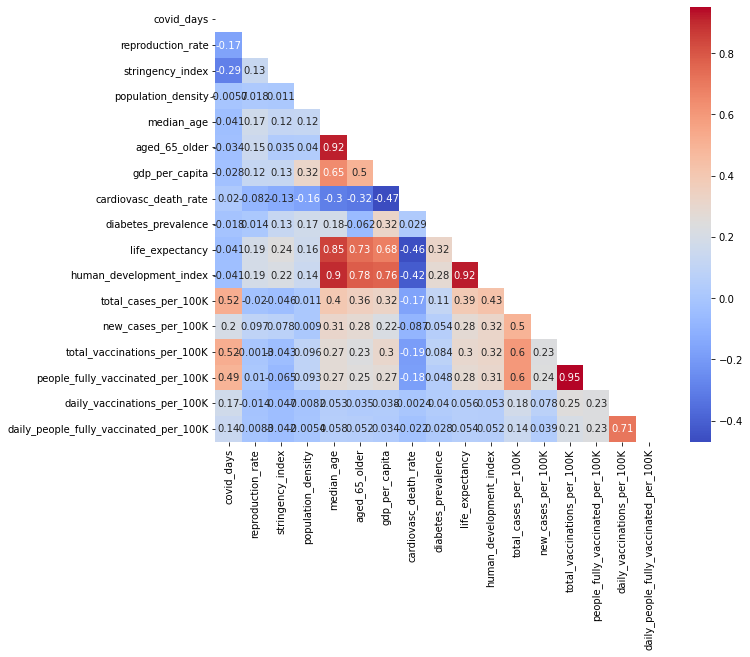

In [9]:
# Visualize the data
# Generate a mask for upper traingle
mask = np.triu(np.ones_like(cases_700_df.corr(), dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(cases_700_df.corr(), annot=True, mask=mask, cmap='coolwarm')
plt.show()

In [10]:
# Define Target variable
y = cases_700_df.new_cases_per_100K
# Define features 
X = cases_700_df.drop(["new_cases_per_100K"], axis=1)

In [11]:
# Show statistical description of features
X.describe()

,covid_days,reproduction_rate,stringency_index,population_density,median_age,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,human_development_index,total_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K
count,84848.000000,84848.000000,84848.000000,84848.000000,84848.000000,84848.000000,84848.000000,84848.000000,84848.000000,84848.000000,84848.000000,84848.000000,84848.000000,84848.000000,84848.000000,84848.000000
mean,385.307915,1.017121,56.650077,202.604440,30.611793,8.986382,18846.414972,259.305251,7.308949,72.692782,0.724566,2051.304927,14984.849142,6103.625424,1377.257369,405.960361
std,175.293743,0.335941,21.353838,709.772872,9.382007,6.495189,19406.874824,122.116848,3.724998,7.680389,0.156551,3249.280863,36467.279304,16120.395109,10349.005086,3959.977414
min,22.000000,-0.030000,0.000000,1.980000,15.100000,1.144000,661.240000,79.370000,0.990000,53.280000,0.394000,0.008100,0.000000,0.000000,0.000000,0.000000
25%,236.000000,0.850000,43.520000,35.879000,21.500000,3.244000,3823.194000,156.139000,4.910000,66.600000,0.584000,65.850000,0.000000,0.000000,0.000000,0.000000
50%,380.000000,1.010000,58.330000,80.291000,29.700000,6.378000,12294.876000,245.465000,6.820000,74.480000,0.756000,384.227900,0.000000,0.000000,0.000000,0.000000
75%,535.000000,1.180000,72.690000,145.725000,39.600000,14.799000,27936.896000,329.635000,8.780000,77.970000,0.852000,2701.485600,1790.000000,0.000000,42.287412,0.000000
max,700.000000,5.820000,100.000000,7915.731000,48.200000,27.049000,116935.600000,724.417000,22.020000,84.630000,0.957000,21701.292100,218900.000000,89580.000000,215677.599716,88401.387517


In [12]:
# Split the data into training and testing datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [13]:
# Check the shapes of training/ testing datasets.
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (63636, 16)
X_test shape: (21212, 16)
y_train shape: (63636,)
y_test shape: (21212,)


In [14]:
# Create a StandardScaler instance 
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [15]:
# Check the scaled data
X_train_scaled

array([[ 0.63987238, -0.11312912,  0.38089879, ..., -0.3600396 ,
        -0.12245797, -0.0975308 ],
       [-1.75323919,  5.07109807, -0.39985944, ..., -0.37929252,
        -0.13332743, -0.10315466],
       [-0.73901572,  0.09423997, -0.26957685, ..., -0.37929252,
        -0.13332743, -0.10315466],
       ...,
       [-1.17205495,  3.05665551, -0.2049042 , ..., -0.37929252,
        -0.13332743, -0.10315466],
       [-0.14643571,  1.19033372,  0.81486165, ..., -0.37929252,
        -0.0928891 , -0.10315466],
       [-0.61366225, -1.47584026, -0.00948032, ..., -0.37929252,
        -0.13332743, -0.10315466]])

In [16]:
# Create a Random Forest Regression instance and train it
rf_model = RandomForestRegressor(n_estimators=128, random_state=78)

# Train the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [17]:
# Evaluate the model.
y_pred = rf_model.predict(X_test_scaled)
y_pred

array([1.50914375e+00, 9.72471875e-01, 5.58413281e-01, ...,
       8.31484375e-03, 3.34156250e-02, 1.01465812e+01])

In [18]:
# Score the model on testing data with R2, MAE, MSE, RMSE.
r2 = r2_score(y_test, y_pred)
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
RMSE = metrics.mean_squared_error(y_test, y_pred, squared=False)

print(f"R-squared (R2 ): {r2: .2f}")
print(f"mean absolute error (MAE): {mae: .2f}")
print(f"mean squared error (MSE): {mse: .2f}")
print(f"Root Mean Squared Error (RMSE): {RMSE: .2f}")

R-squared (R2 ):  0.78
mean absolute error (MAE):  2.62
mean squared error (MSE):  80.40
Root Mean Squared Error (RMSE):  8.97


In [19]:
# Check the training score
training_score = rf_model.score(X_train_scaled, y_train)
print(f"The training score for the Random Forest Regression model on 17 features is {training_score: .3f}.")

The training score for the Random Forest Regression model on 17 features is  0.971.


In [20]:
# Check the testing score
testing_score = rf_model.score(X_test_scaled, y_test)
print(f"The testing score for the Random Forest Regression model on 17 features is {testing_score: .3f}.")

The testing score for the Random Forest Regression model on 17 features is  0.778.


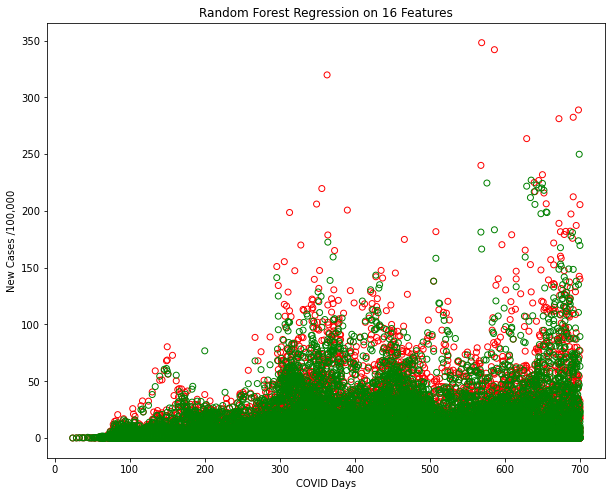

In [22]:
# Visualize the predication against the actual values
plt.figure(figsize=(10, 8))
plt.scatter(X_test['covid_days'].values, y_test, facecolors='none', edgecolors='r')
plt.scatter(X_test['covid_days'].values, y_pred, facecolors='none', edgecolors='green')

plt.title('Random Forest Regression on 16 Features')
plt.xlabel('COVID Days')
plt.ylabel('New Cases /100,000')
plt.show() 

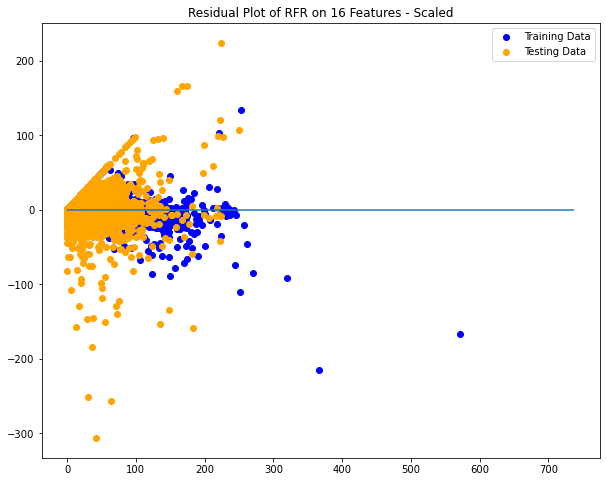

In [24]:
# Plot the predictions and their residuals for the training and testing data - SCALED.

plt.figure(figsize=(10, 8))
plt.scatter(rf_model.predict(X_train_scaled), rf_model.predict(X_train_scaled) - y_train, c="blue", label="Training Data")
plt.scatter(rf_model.predict(X_test_scaled), rf_model.predict(X_test_scaled) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y.min(), xmax=y.max())
plt.title("Residual Plot of RFR on 16 Features - Scaled")
plt.show()

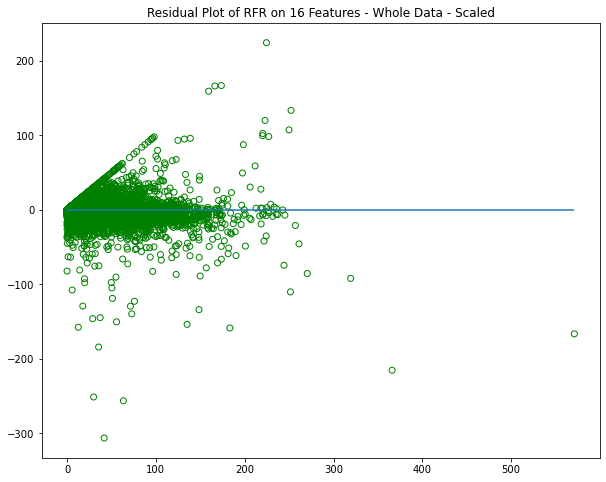

In [25]:
# Scale the whole data
X_scaled = X_scaler.transform(X)
pred_16_scaled = rf_model.predict(X_scaled)
# Plot predictions from scaled data and their Residuals
plt.figure(figsize=(10, 8))
plt.scatter(pred_16_scaled, pred_16_scaled - y, facecolors='none', edgecolors='green')
plt.hlines(y=0, xmin=pred_16_scaled.min(), xmax=pred_16_scaled.max())
plt.title("Residual Plot of RFR on 16 Features - Whole Data - Scaled")
plt.show()

In [ ]:
# # Create a new focused DataFrame of results of regression with their errors 
# predictions = rf_model.predict(X)
# regression_notscaled_df = pd.DataFrame({"Actual": y, "Predicted": predictions, "Error": predictions - y})[["Actual", "Predicted", "Error"]]
# regression_notscaled_df.head(5)

In [26]:
# Scale the whole data
# X_scaled = X_scaler.transform(X)
# pred_16_scaled = rf_model.predict(X_scaled)
regression_scaled_df = pd.DataFrame({"Actual": y, "Predicted": pred_16_scaled, "Residuals": pred_16_scaled - y})[["Actual", "Predicted", "Residuals"]]
regression_scaled_df.head(5)

,Actual,Predicted,Residuals
id_row,,,
34,0.0201,0.032000,0.011900
35,0.0000,0.021384,0.021384
36,0.1305,0.043727,-0.086773
37,0.0653,0.061342,-0.003958
38,0.1079,0.091566,-0.016334


In [27]:
# Add a new column "predictions" to the original Dataframe that holds the actual new cases. 
pred_700d_rfr_df = cases_700_df.copy()
pred_700d_rfr_df['new_cases_per_100K_predictions'] = pred_16_scaled
print(pred_700d_rfr_df.shape)
pred_700d_rfr_df.head()

(84848, 18)


,covid_days,reproduction_rate,stringency_index,population_density,median_age,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,human_development_index,total_cases_per_100K,new_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K,new_cases_per_100K_predictions
id_row,,,,,,,,,,,,,,,,,,
34,88,1.52,67.59,54.422,18.6,2.581,1803.987,597.029,9.59,64.83,0.511,0.2862,0.0201,0.0,0.0,0.0,0.0,0.032000
35,89,1.52,67.59,54.422,18.6,2.581,1803.987,597.029,9.59,64.83,0.511,0.2862,0.0000,0.0,0.0,0.0,0.0,0.021384
36,90,1.53,67.59,54.422,18.6,2.581,1803.987,597.029,9.59,64.83,0.511,0.4167,0.1305,0.0,0.0,0.0,0.0,0.043727
37,91,1.52,67.59,54.422,18.6,2.581,1803.987,597.029,9.59,64.83,0.511,0.4820,0.0653,0.0,0.0,0.0,0.0,0.061342
38,92,1.52,67.59,54.422,18.6,2.581,1803.987,597.029,9.59,64.83,0.511,0.5899,0.1079,0.0,0.0,0.0,0.0,0.091566


In [28]:
# Add a new column "residuals" to the Dataframe that holds the actual new cases and predictions.
pred_700d_rfr_df['Residuals'] = pred_700d_rfr_df['new_cases_per_100K_predictions'] - pred_700d_rfr_df['new_cases_per_100K']
pred_700d_rfr_df.sample(5)

,covid_days,reproduction_rate,stringency_index,population_density,median_age,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,human_development_index,total_cases_per_100K,new_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K,new_cases_per_100K_predictions,Residuals
id_row,,,,,,,,,,,,,,,,,,,
122878,141,0.84,80.56,81.721,29.1,5.732,5591.597,202.104,4.61,67.13,0.583,0.3631,0.0000,0.0,0.0,0.000000,0.0,0.000278,0.000278
138888,585,1.57,87.04,778.202,20.4,3.043,4449.898,265.910,10.59,74.05,0.708,6088.7202,5.6675,19770.0,0.0,17.117399,0.0,5.022983,-0.644517
146294,227,0.97,77.78,227.322,31.9,1.307,116935.600,176.690,16.52,80.23,0.848,3917.6953,9.4522,0.0,0.0,0.000000,0.0,9.401562,-0.050638
4445,212,1.22,79.17,23.890,16.8,2.405,5819.495,276.045,3.94,61.15,0.581,3.3831,0.1149,0.0,0.0,0.000000,0.0,0.096879,-0.018021
146320,253,1.00,64.81,227.322,31.9,1.307,116935.600,176.690,16.52,80.23,0.848,4130.7288,7.0295,0.0,0.0,0.000000,0.0,7.427233,0.397733


In [29]:
# # Export the RFR predictions DataFrame to a csv file.
# pred_700d_rfr_outpath = Path("./Resources/pred_700d_rfr.csv")
# pred_700d_rfr_df.to_csv(pred_700d_rfr_outpath, index=True)

## Adding Predictions and Residuals to Original DataFrame

In [30]:
# Add a new column "predictions" to the original Dataframe that holds the actual new cases. 
pred_700d_rfr_all_df = df.copy()
pred_700d_rfr_all_df['new_cases_per_100K_predictions'] = pred_16_scaled
print(pred_700d_rfr_all_df.shape)
pred_700d_rfr_all_df.head()

(84848, 26)


,location,covid_days,total_cases,new_cases,reproduction_rate,total_vaccinations,people_fully_vaccinated,stringency_index,population,population_density,...,human_development_index,daily_vaccinations,daily_people_fully_vaccinated,total_cases_per_100K,new_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K,new_cases_per_100K_predictions
id_row,,,,,,,,,,,,,,,,,,,,,
34,Afghanistan,88,114.0,8.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,0.511,0.0,0.0,0.2862,0.0201,0.0,0.0,0.0,0.0,0.032000
35,Afghanistan,89,114.0,0.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,0.511,0.0,0.0,0.2862,0.0000,0.0,0.0,0.0,0.0,0.021384
36,Afghanistan,90,166.0,52.0,1.53,0.0,0.0,67.59,39835428.0,54.422,...,0.511,0.0,0.0,0.4167,0.1305,0.0,0.0,0.0,0.0,0.043727
37,Afghanistan,91,192.0,26.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,0.511,0.0,0.0,0.4820,0.0653,0.0,0.0,0.0,0.0,0.061342
38,Afghanistan,92,235.0,43.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,0.511,0.0,0.0,0.5899,0.1079,0.0,0.0,0.0,0.0,0.091566


In [32]:
# Add a new column "residuals" to the Dataframe that holds the actual new cases and predictions.
pred_700d_rfr_all_df['Residuals'] = pred_700d_rfr_all_df['new_cases_per_100K_predictions'] - pred_700d_rfr_all_df['new_cases_per_100K']
print(pred_700d_rfr_all_df.shape)
pred_700d_rfr_all_df.sample(5)

(84848, 27)


,location,covid_days,total_cases,new_cases,reproduction_rate,total_vaccinations,people_fully_vaccinated,stringency_index,population,population_density,...,daily_vaccinations,daily_people_fully_vaccinated,total_cases_per_100K,new_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K,new_cases_per_100K_predictions,Residuals
id_row,,,,,,,,,,,,,,,,,,,,,
52508,El Salvador,122,446.0,22.0,1.29,0.0,0.0,94.44,6518500.0,307.811,...,0.0,0.0,6.8421,0.3375,0.0,0.0,0.00000,0.000000,0.373852,0.036352
23465,Bosnia and Herzegovina,395,121497.0,0.0,1.01,0.0,0.0,42.59,3263459.0,68.496,...,0.0,0.0,3722.9516,0.0000,0.0,0.0,0.00000,0.000000,2.629493,2.629493
21711,Bolivia,317,143069.0,180.0,0.97,0.0,0.0,81.48,11832936.0,10.202,...,0.0,0.0,1209.0744,1.5212,0.0,0.0,0.00000,0.000000,1.453334,-0.067866
63,Afghanistan,117,1531.0,68.0,1.56,0.0,0.0,84.26,39835428.0,54.422,...,0.0,0.0,3.8433,0.1707,0.0,0.0,0.00000,0.000000,0.229423,0.058723
89591,Italy,595,4456765.0,7159.0,1.04,74825498.0,35005039.0,63.89,60367471.0,205.859,...,260098.0,120058.0,7382.7260,11.8590,123950.0,57990.0,430.85787,198.878631,11.685615,-0.173385


In [33]:
# # Export the RFR predictions DataFrame to a csv file.
# pred_700d_rfr_all_df_oupath = Path("./Resources/pred_700d_rfr_all.csv")
# pred_700d_rfr_all_df.to_csv(pred_700d_rfr_all_df_oupath, index=True)